In [17]:
import os
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import cluster
import seaborn as sns
from math import log

# Je me positionne dans mon répertoire de travail personnel
os.chdir("C:\\Users\\Julien Gremillot\\OneDrive\\Documents\\OpenClassrooms\\Segmentez des clients d'un site e-commerce")
os.getcwd()

# Lecture du fichier issu de l'analyse exploratoire
clients = pd.read_csv("client_infos.csv")

In [4]:
clients.shape

(96096, 44)

In [10]:
clients.head()

,vouchers_value,credit_card_value,boleto_value,debit_card_value,sum_payments,sum_items_prices,freight_value,nb_items,product_name_lenght,product_description_lenght,...,avg_product_name_lenght,avg_product_description_lenght,avg_product_photos_qty,avg_review_len,customer_zip_code_prefix,customer_city,customer_state,max_freight_value,time_since_last_order,delivery_time
0,0.0,141.90,0.0,0.0,141.90,129.90,12.00,1.0,60.0,236.0,...,60.0,236.0,1.0,111.0,7787,cajamar,SP,12.00,1.059539e+08,553930.0
1,0.0,27.19,0.0,0.0,27.19,18.90,8.29,1.0,56.0,635.0,...,56.0,635.0,1.0,0.0,6053,osasco,SP,8.29,1.062122e+08,283875.0
2,0.0,86.22,0.0,0.0,86.22,69.00,17.22,1.0,49.0,177.0,...,49.0,177.0,3.0,0.0,88115,sao jose,SC,17.22,1.427238e+08,2223224.0
3,0.0,43.62,0.0,0.0,43.62,25.99,17.63,1.0,43.0,1741.0,...,43.0,1741.0,5.0,12.0,66812,belem,PA,17.63,1.240635e+08,1731204.0
4,0.0,196.89,0.0,0.0,196.89,180.00,16.89,1.0,58.0,794.0,...,58.0,794.0,3.0,0.0,18040,sorocaba,SP,16.89,1.212150e+08,1135394.0


In [12]:
clients.dtypes

vouchers_value                    float64
credit_card_value                 float64
boleto_value                      float64
debit_card_value                  float64
sum_payments                      float64
sum_items_prices                  float64
freight_value                     float64
nb_items                          float64
product_name_lenght               float64
product_description_lenght        float64
product_photos_qty                float64
culture                           float64
diy                               float64
fashion                           float64
food                              float64
games                             float64
hightech                          float64
home                              float64
leisure                           float64
misc                              float64
nb_orders                           int64
nb_week_orders                      int64
nb_weekend_orders                   int64
favorite_dayofweek                

La segmentation RFM ou méthode RFM est une méthode de segmentation principalement développée à l'origine pour les actions de marketing direct des véadistes et qui s'applique désormais également aux acteurs du e-commerce et du commerce traditionnel.

La segmentation RFM prend en compte la Récence (date de la dernière commande), la Fréquence des commandes et le Montant (de la dernière commande ou sur une période donnée) pour établir des segments de clients homogènes.

La segmentation RFM permet de cibler les offres, d'établir des segments basés sur la valeur des clients et de prévenir l'attrition en identifiant des segments à risque.

Dans notre jeu de données, on a donc :
- la Récence qui correspond à notre colonne 'time_since_last_order'.
- la Fréquence qui correspond à notre colonne 'nb_orders'.
- le Montant qui correspond à notre colonne 'sum_payments'.

Pour chacune de ces variables on va vérifier la distribution.

In [33]:
# on supprime les 3 lignes où les clients n'ont fait aucun paiement, ce qui semblent erroné.
clients[clients['sum_payments'] == 0]

,vouchers_value,credit_card_value,boleto_value,debit_card_value,sum_payments,sum_items_prices,freight_value,nb_items,product_name_lenght,product_description_lenght,...,avg_freight_value,avg_popularite,avg_product_name_lenght,avg_product_description_lenght,avg_product_photos_qty,avg_review_len,customer_zip_code_prefix,max_freight_value,time_since_last_order,delivery_time
29977,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,...,0.00,0.000000,0.0,0.0,0.0,106.0,1151,0.00,9.643373e+07,-1.535470e+09
49312,0.0,0.0,0.0,0.0,0.0,134.97,8.49,3.0,102.0,3108.0,...,8.49,0.054737,102.0,3108.0,3.0,46.0,14600,8.49,1.579619e+08,4.735860e+06
56519,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,...,0.00,0.000000,0.0,0.0,0.0,125.0,4685,0.00,9.591966e+07,-1.535984e+09


In [34]:
clients.drop(clients.loc[clients['sum_payments'] == 0].index, inplace=True)

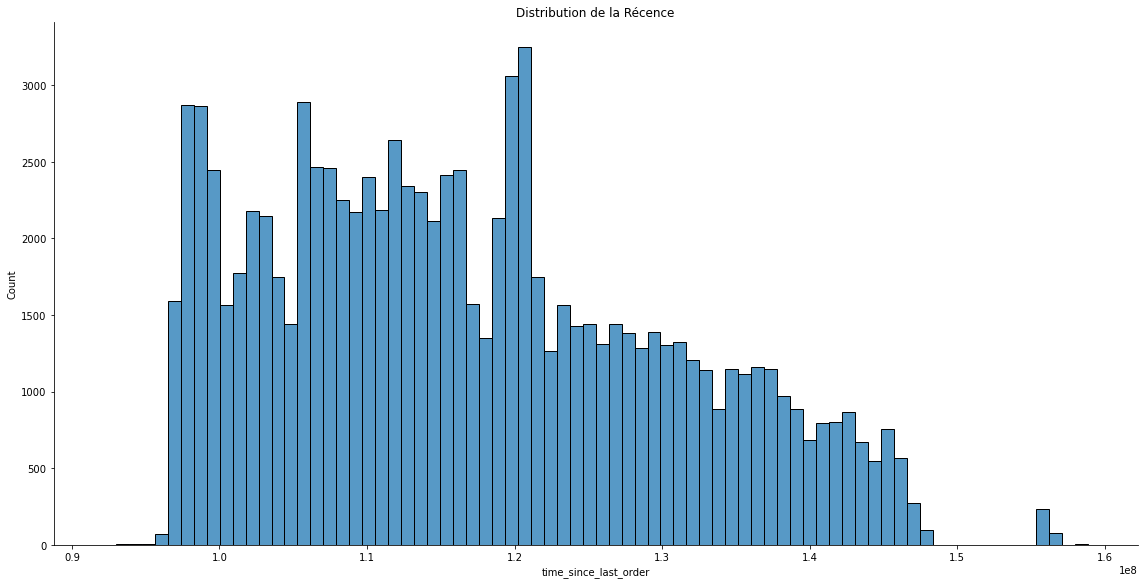

In [44]:
sns.displot(clients, x="time_since_last_order", height=8, aspect=2).set(
    title='Distribution de la Récence')

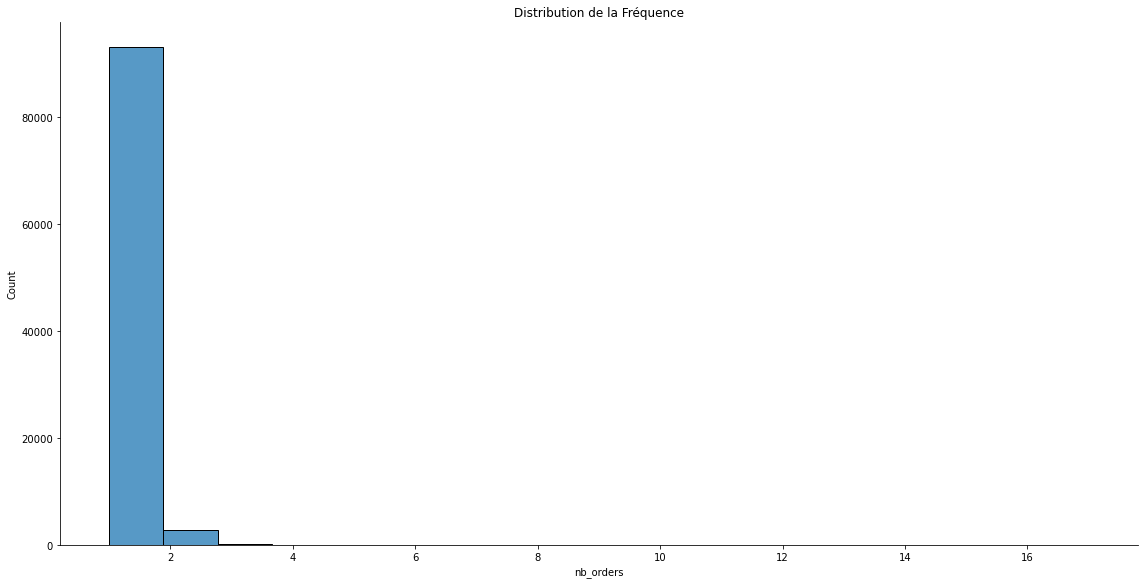

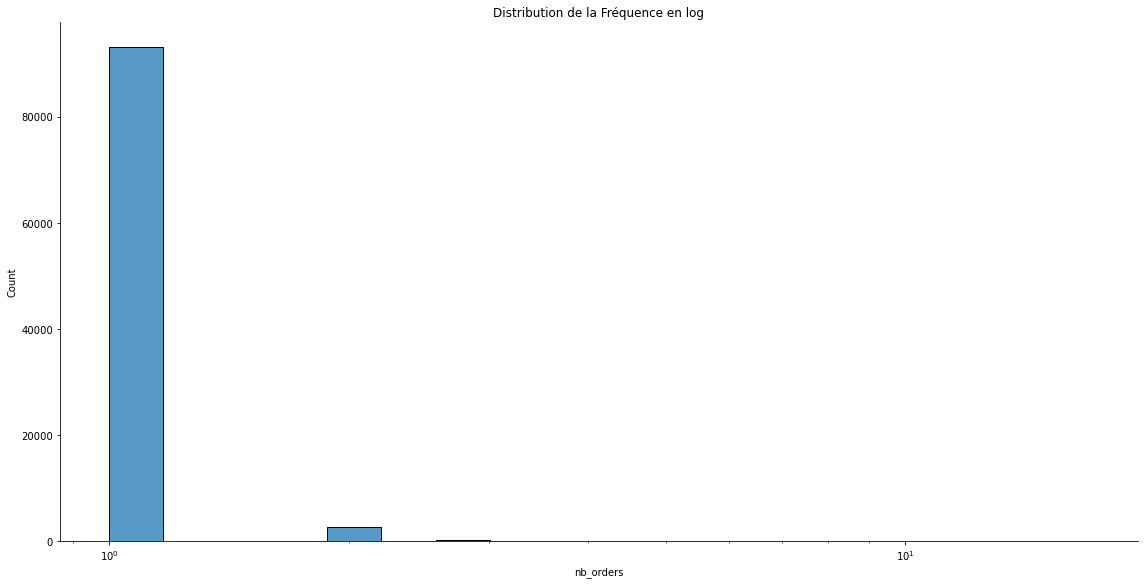

In [45]:
sns.displot(clients, x="nb_orders", height=8, aspect=2).set(title='Distribution de la Fréquence')
sns.displot(clients, x="nb_orders", log_scale=True, height=8, aspect=2).set(title='Distribution de la Fréquence en log')

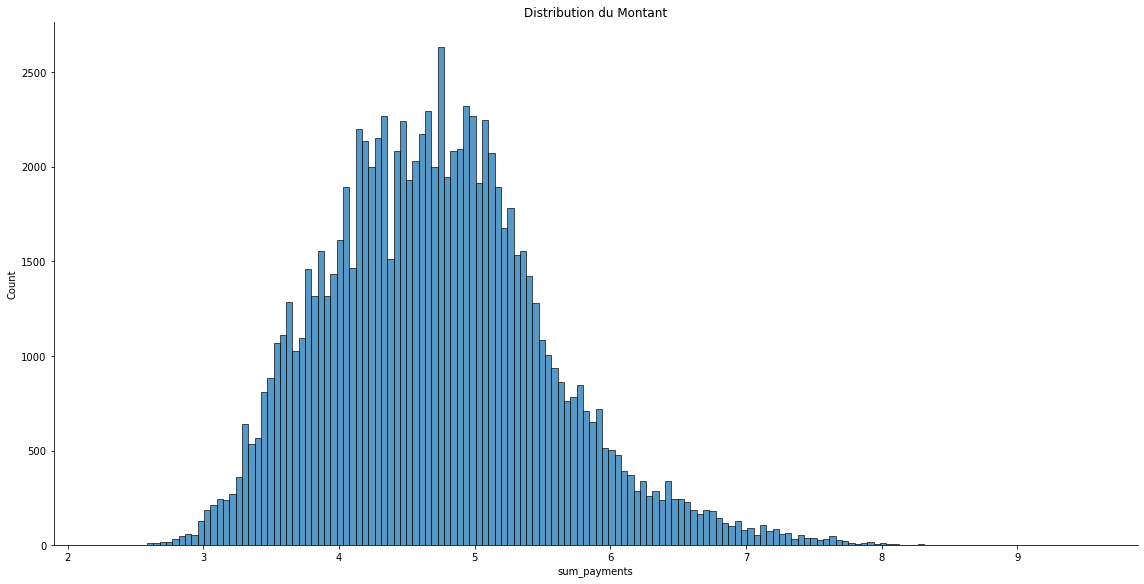

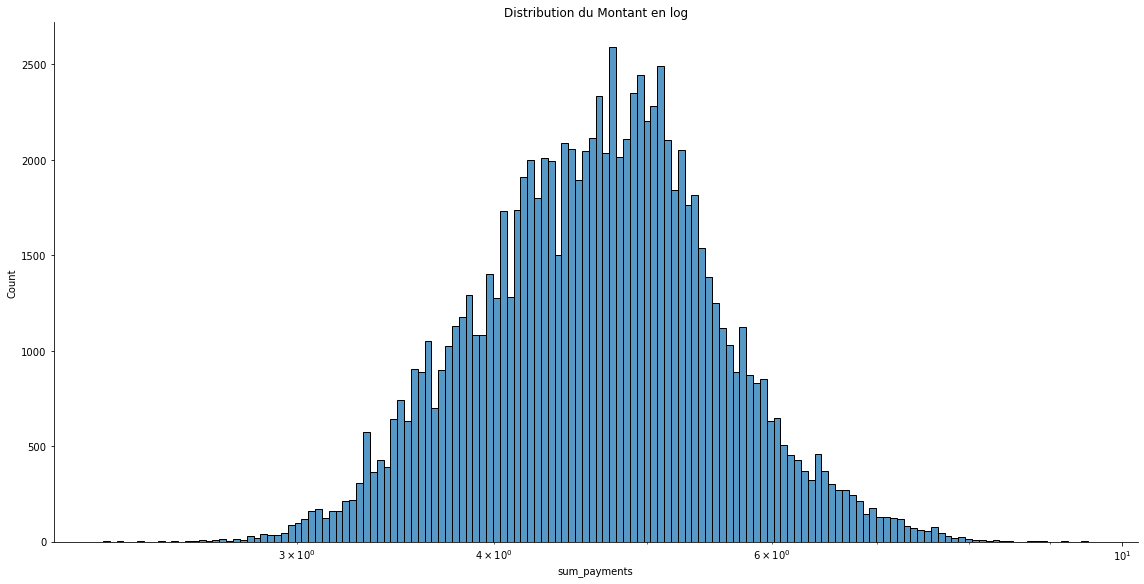

In [46]:
sns.displot(clients, x="sum_payments", height=8, aspect=2).set(title='Distribution du Montant')
sns.displot(clients, x="sum_payments", log_scale=True, height=8, aspect=2).set(title='Distribution du Montant en log')

On constate que la Récence est plutôt bien distribuée, que la Fréquence ne l'est pas vraiment mais qu'un passage au log ne change rien. Le passage au log est surtout intéressant pour le Montant, on change donc le contenu de la colonne "sum_payments".

In [37]:
clients['sum_payments'] = [log(p) for p in clients['sum_payments']]

C:\anaconda\lib\site-packages\seaborn\axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


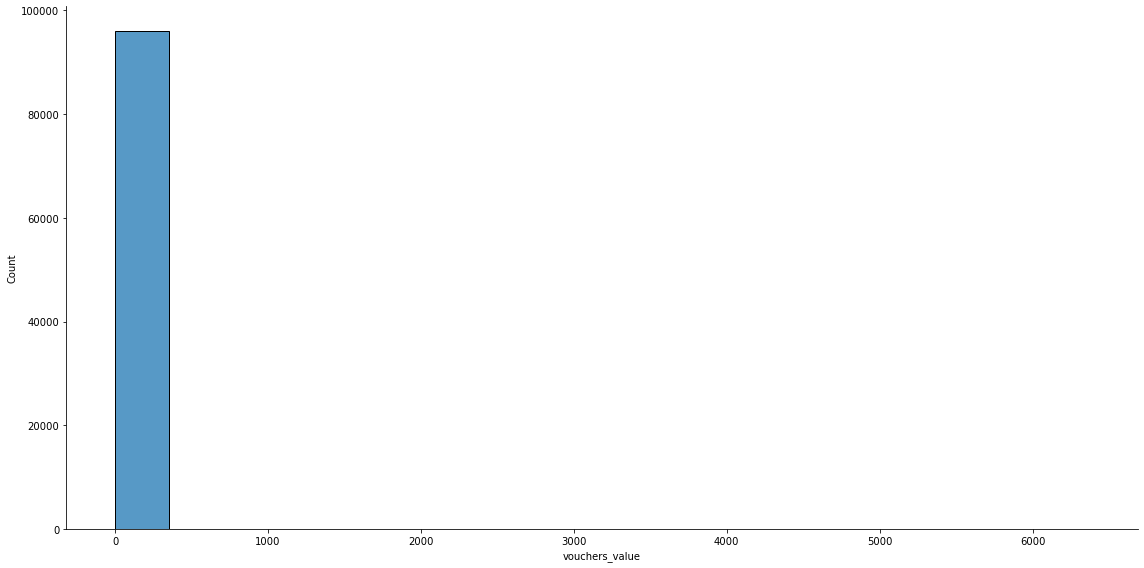

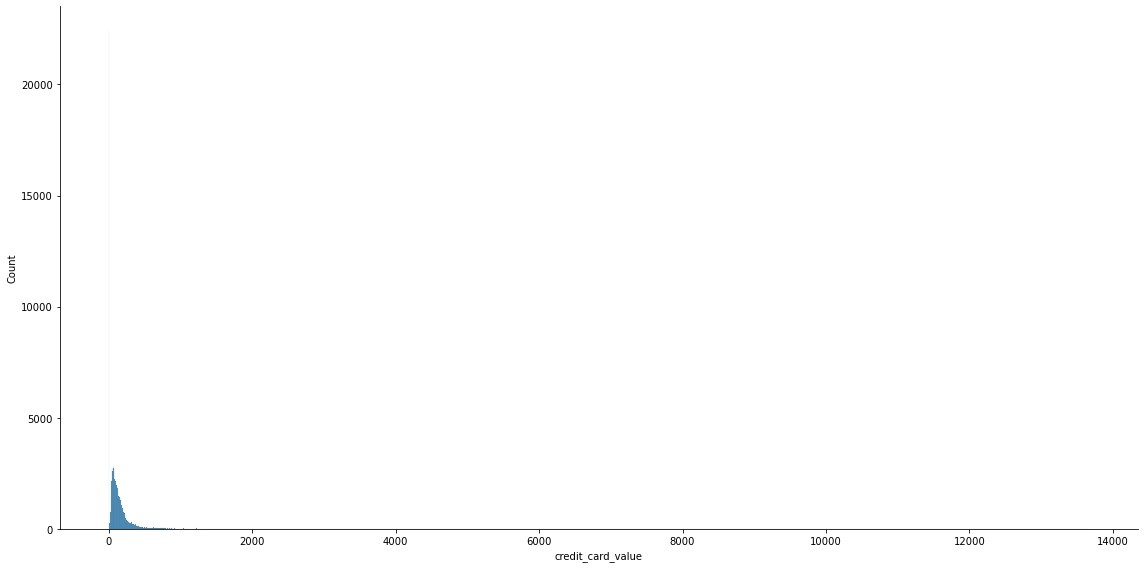

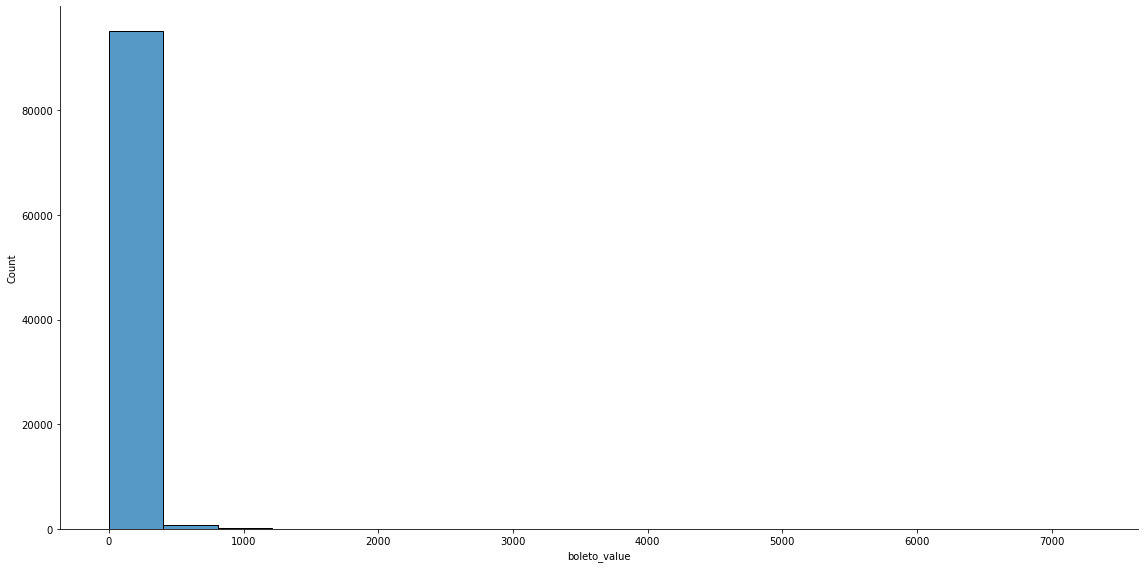

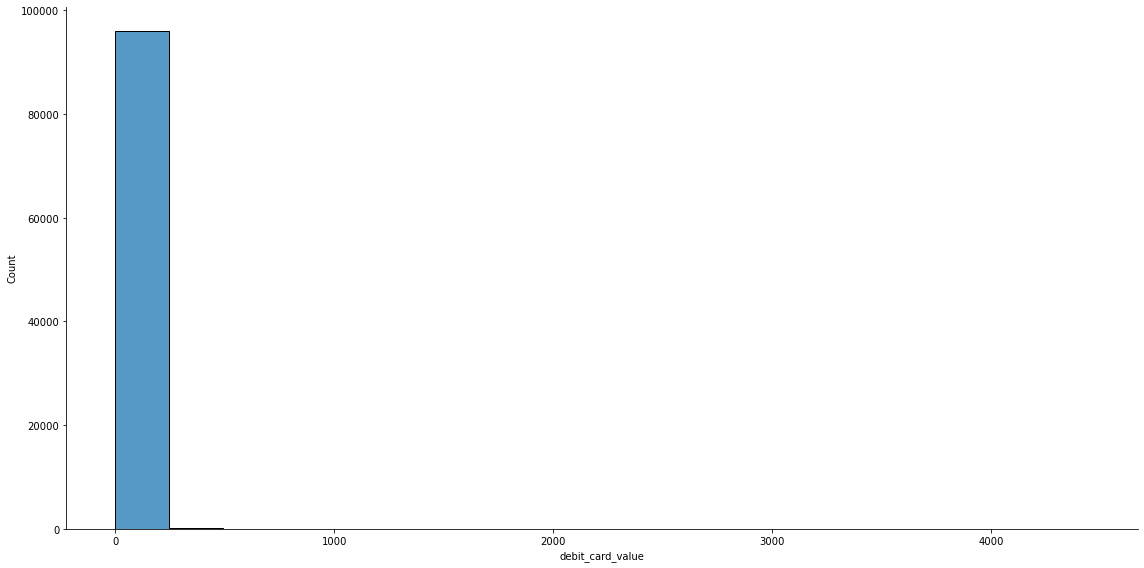

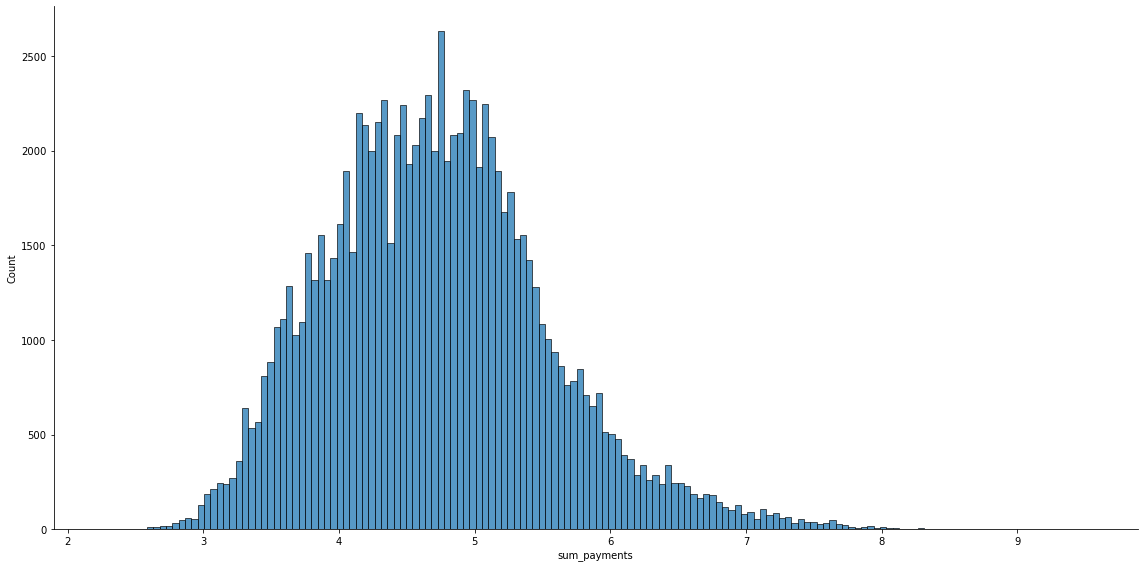

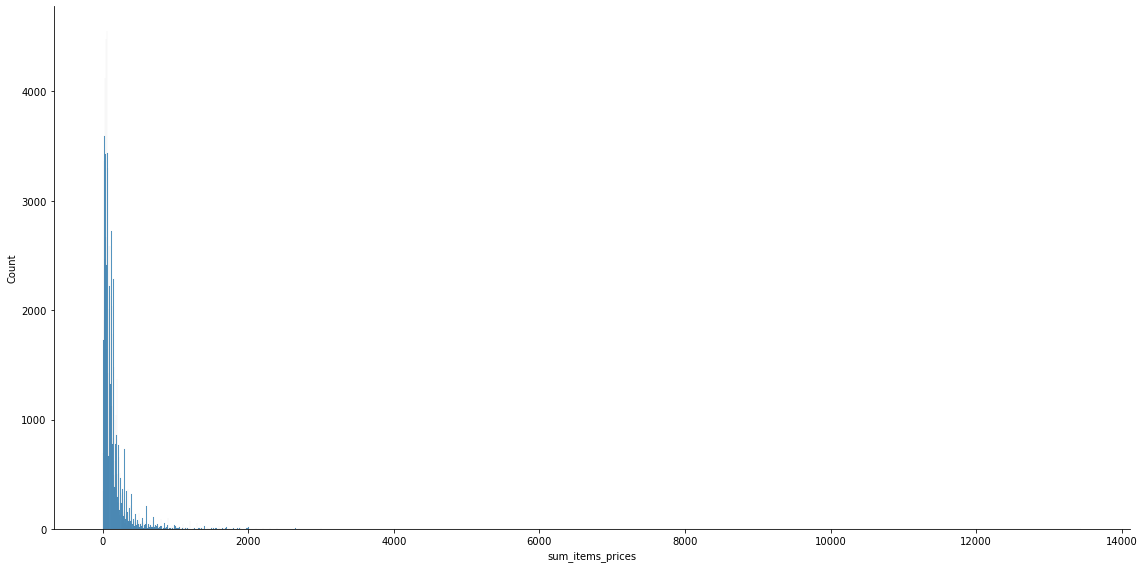

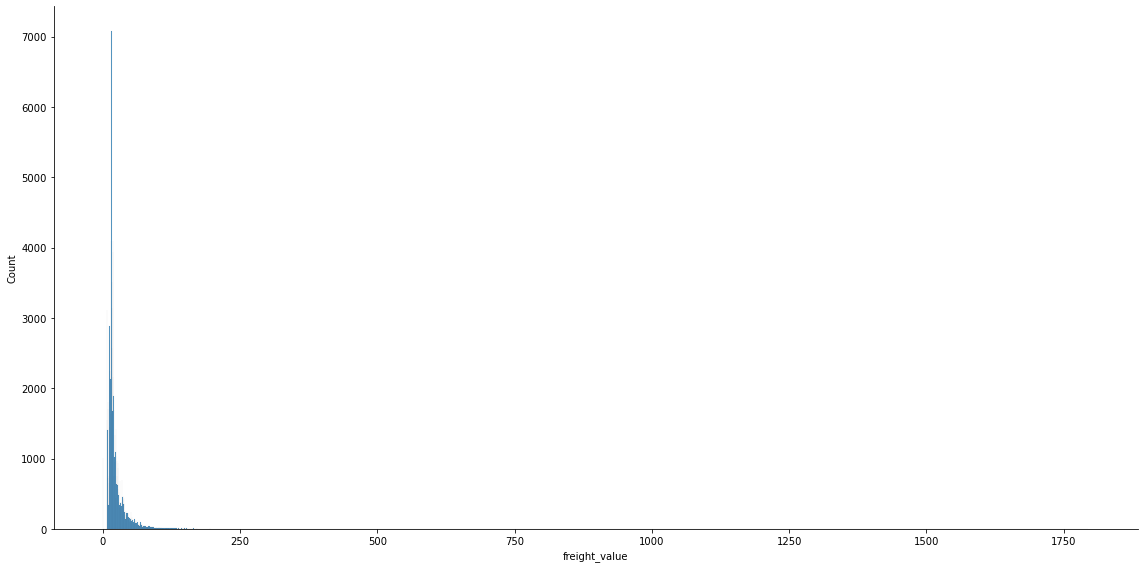

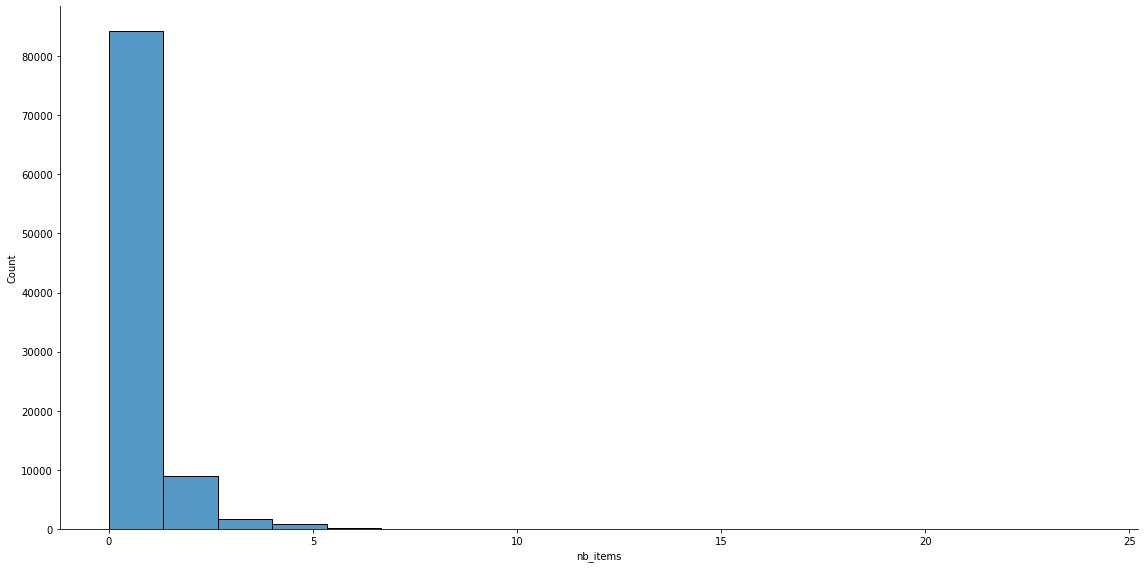

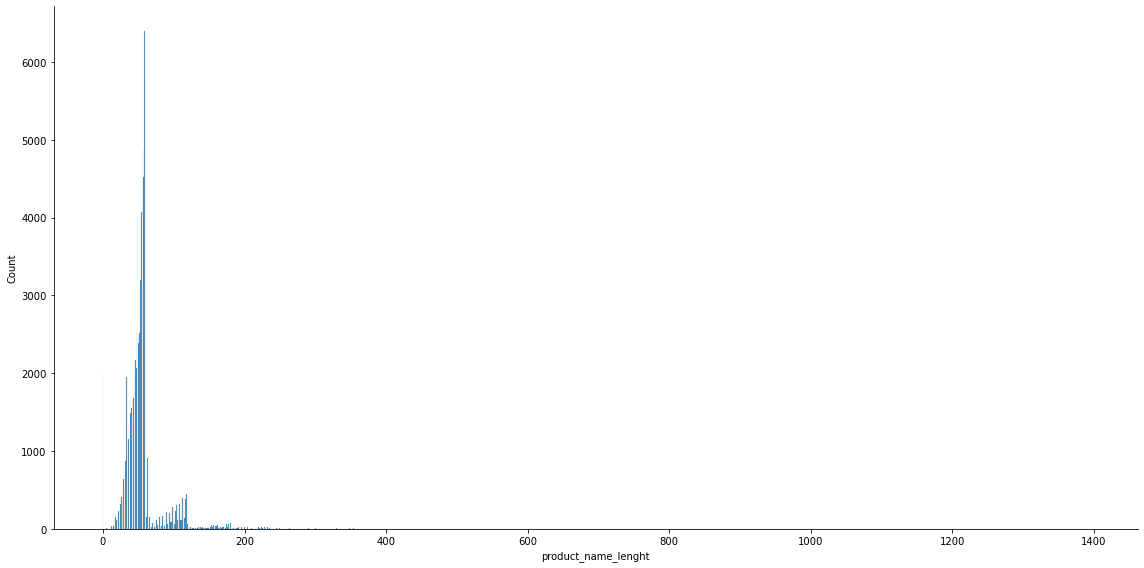

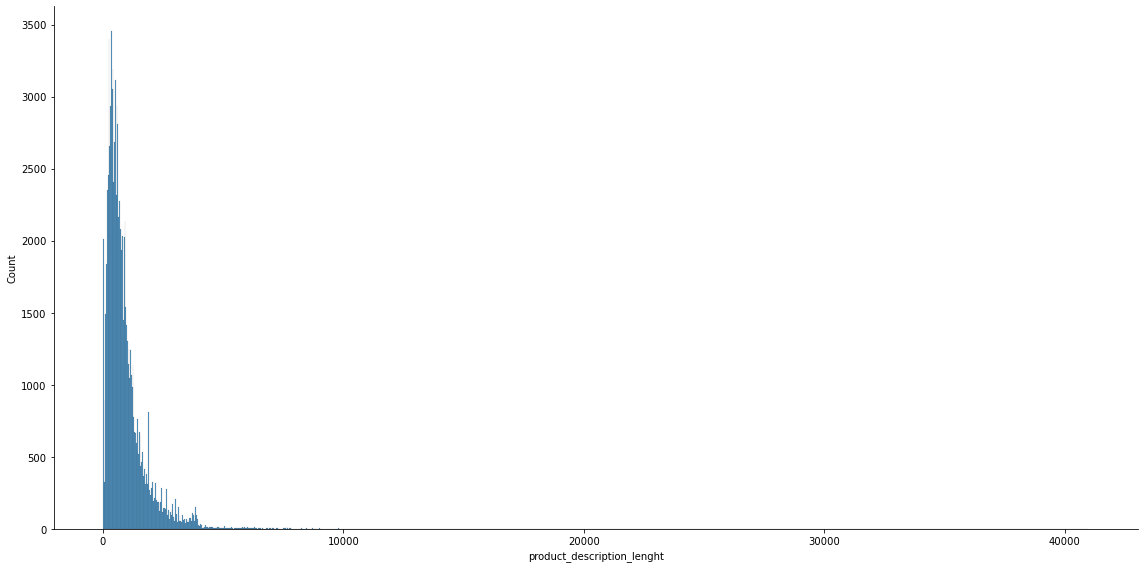

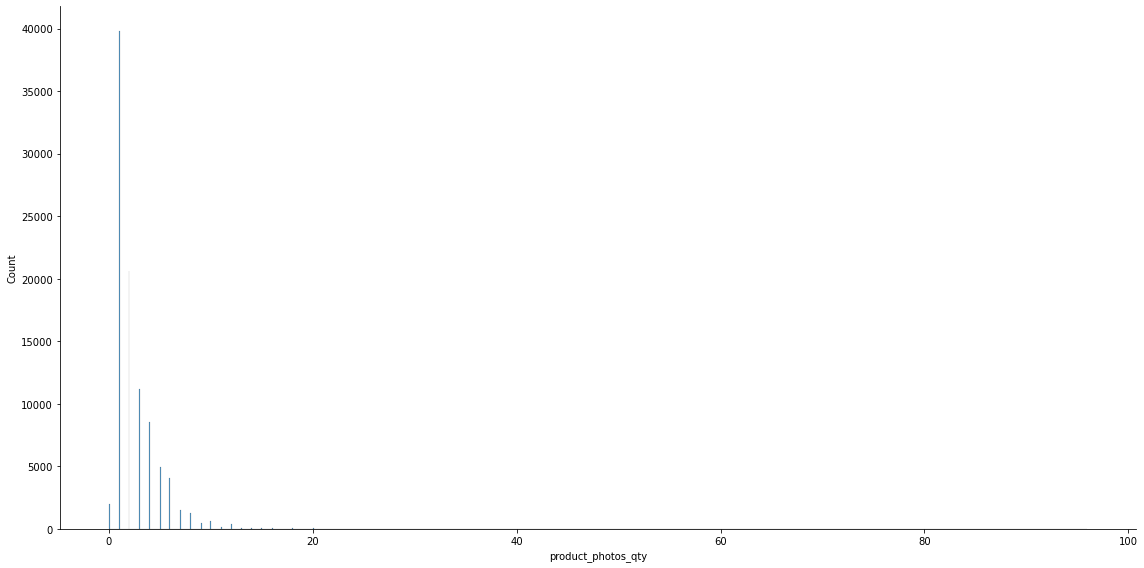

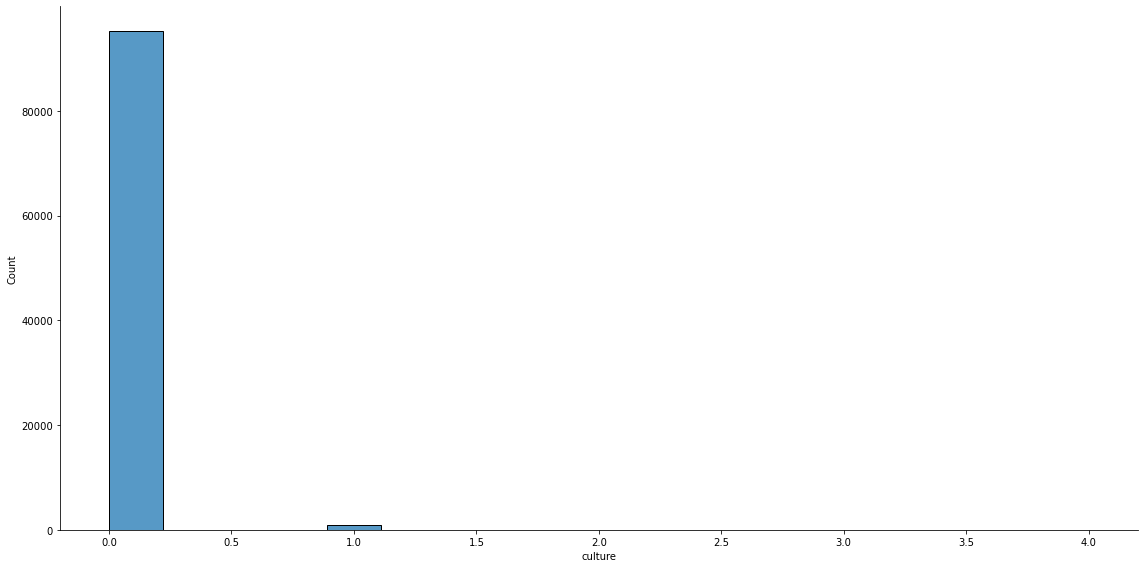

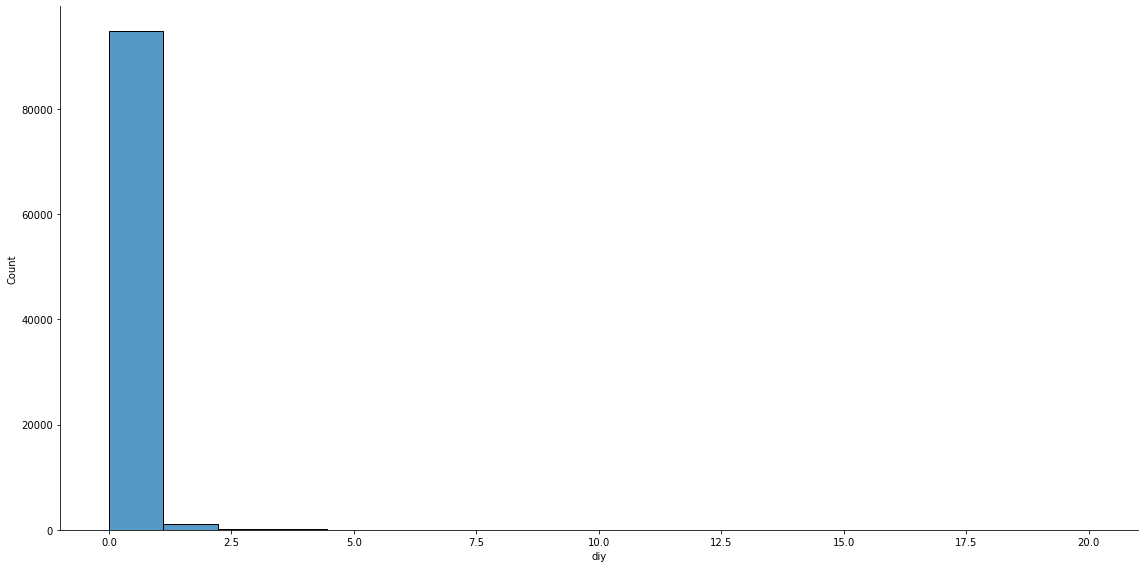

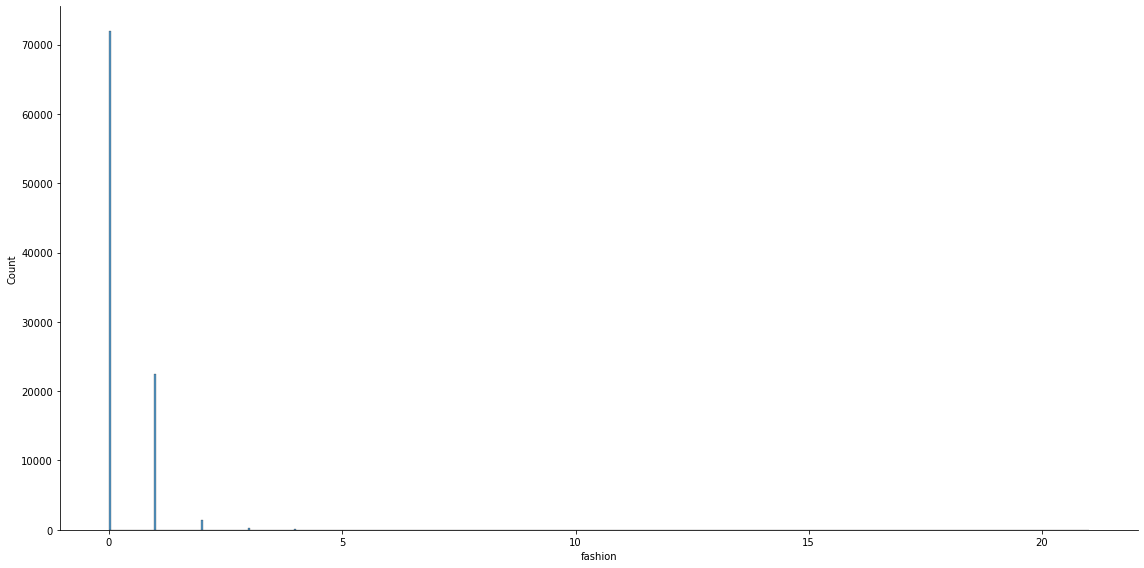

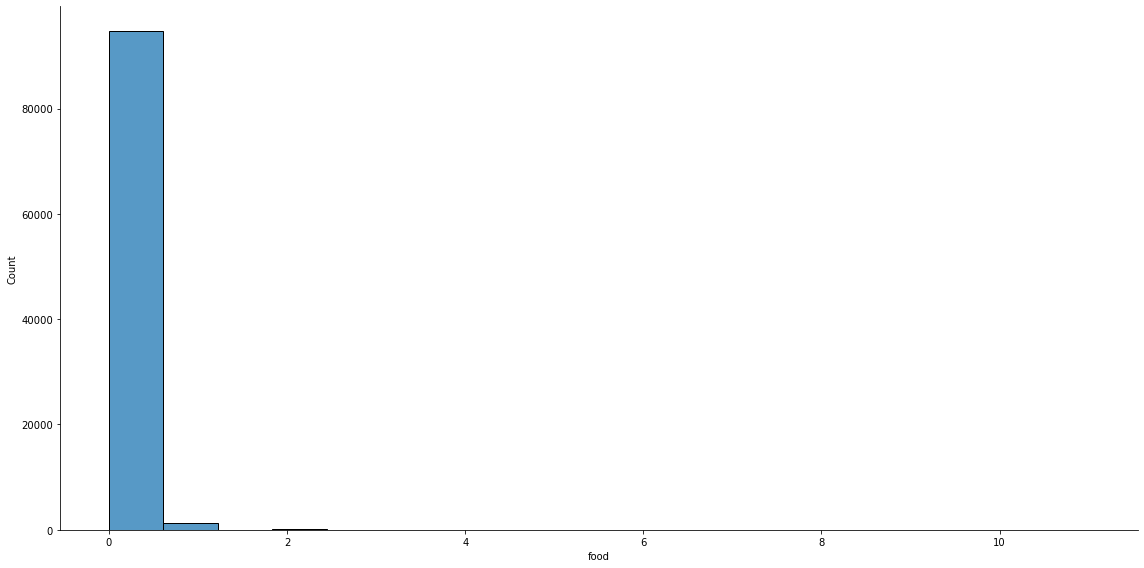

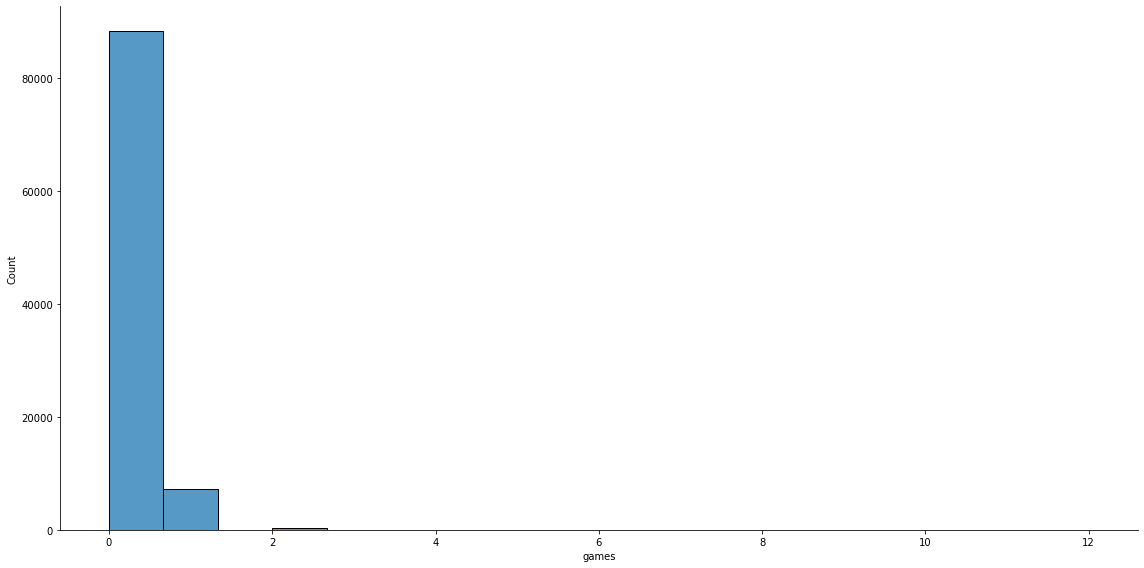

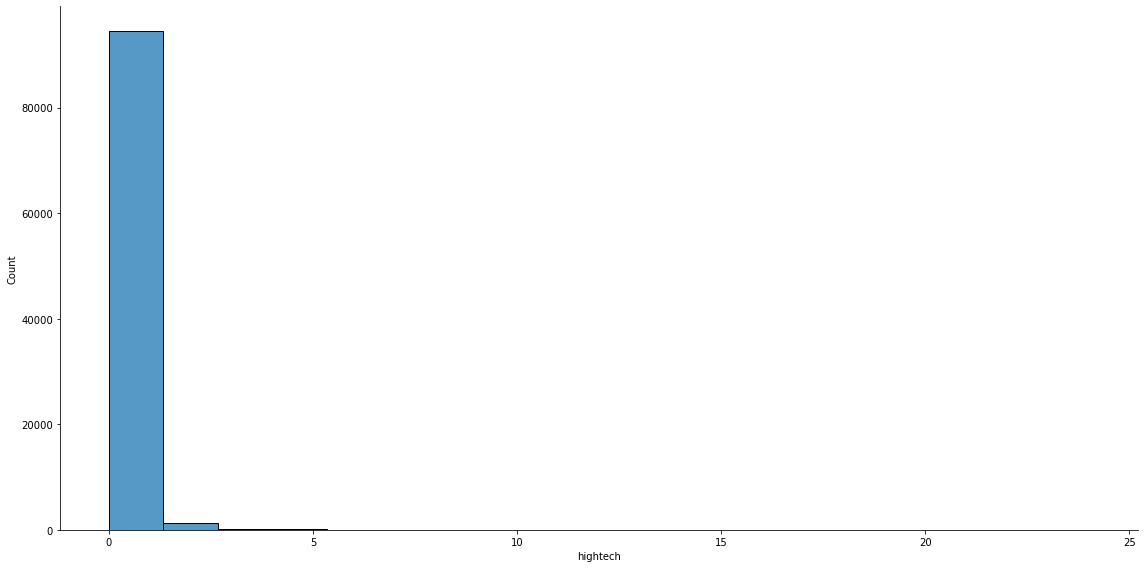

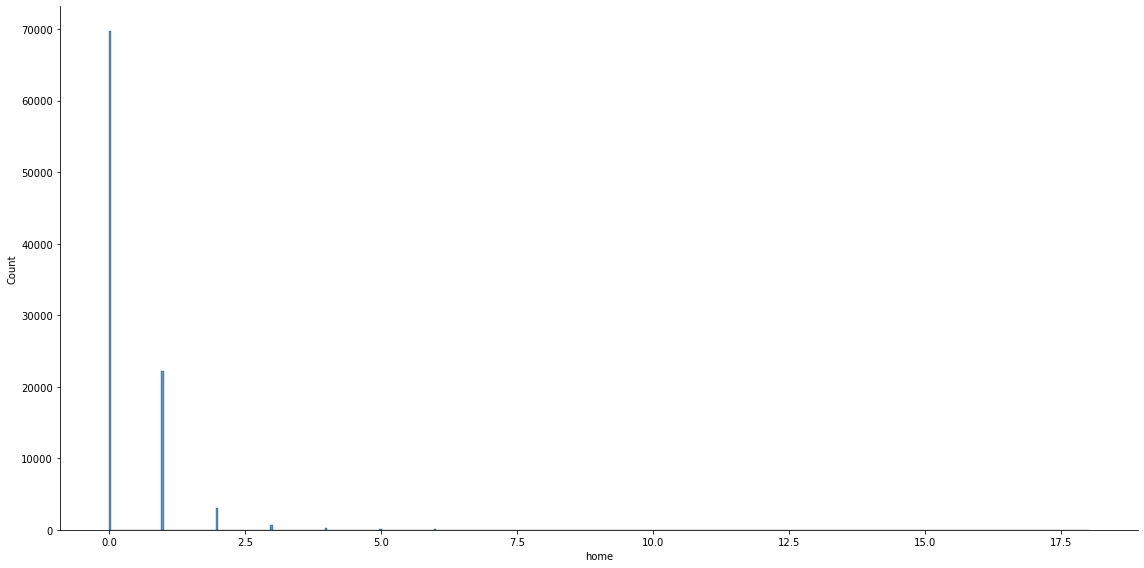

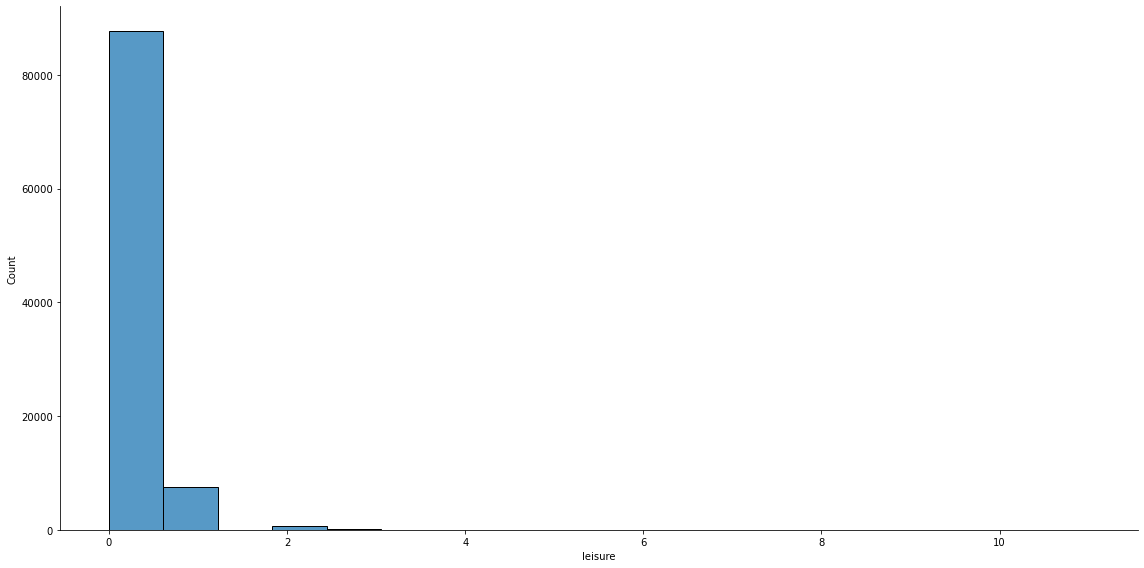

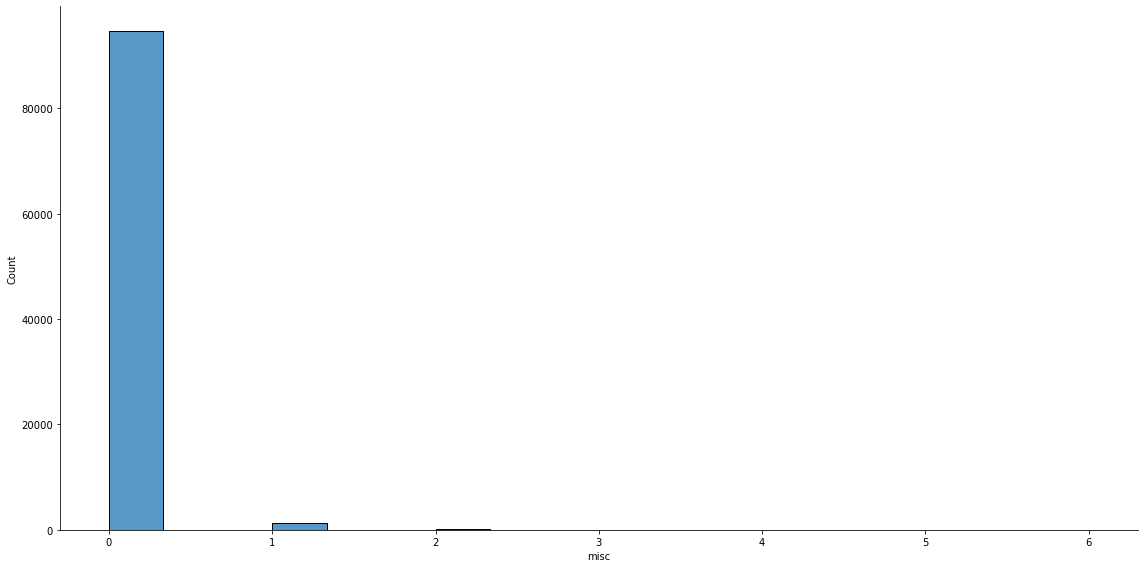

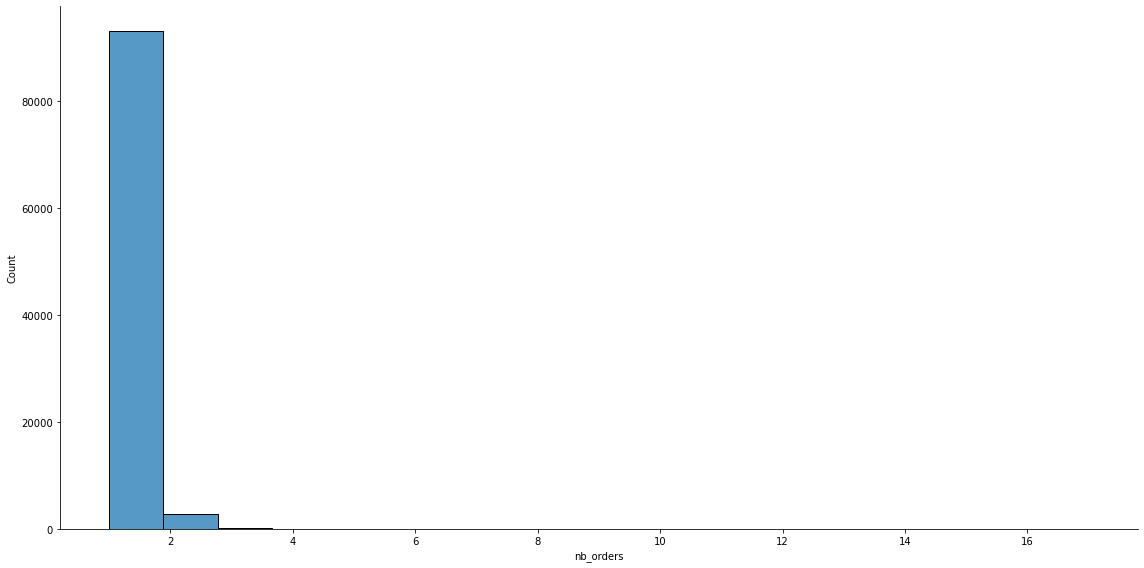

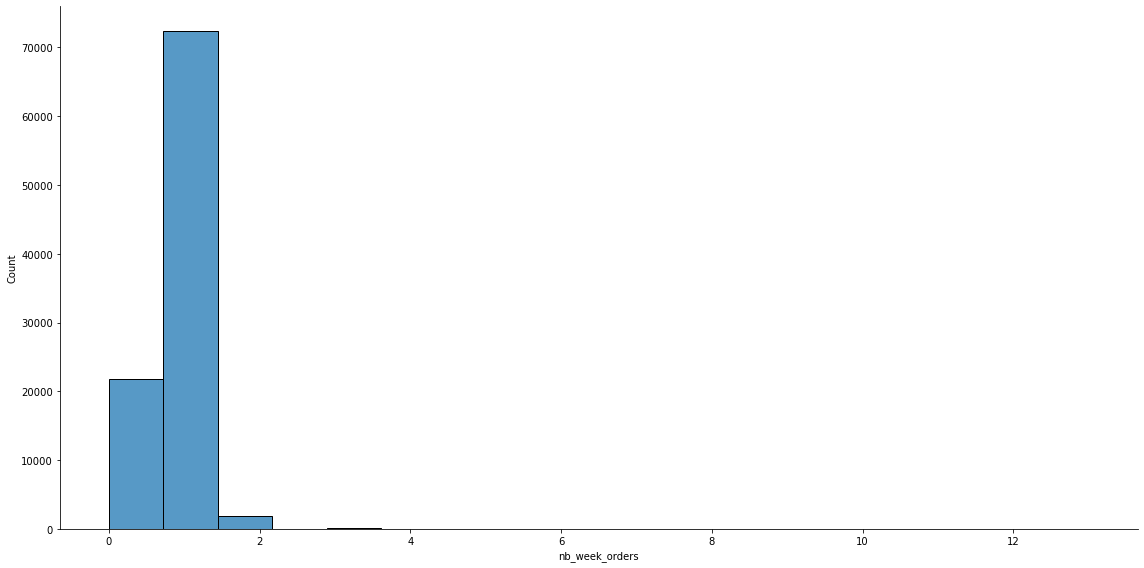

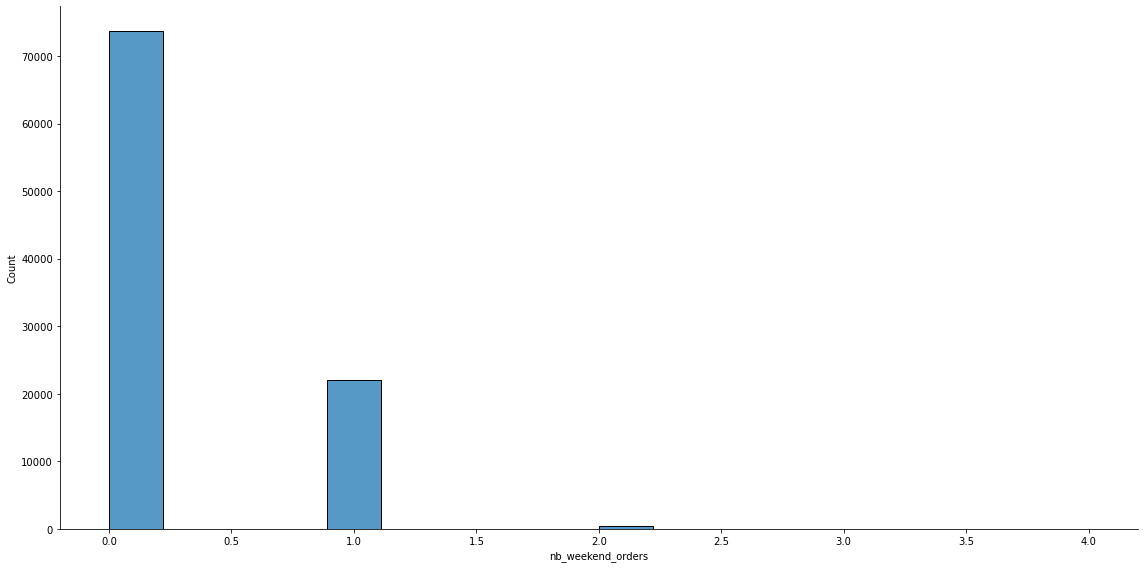

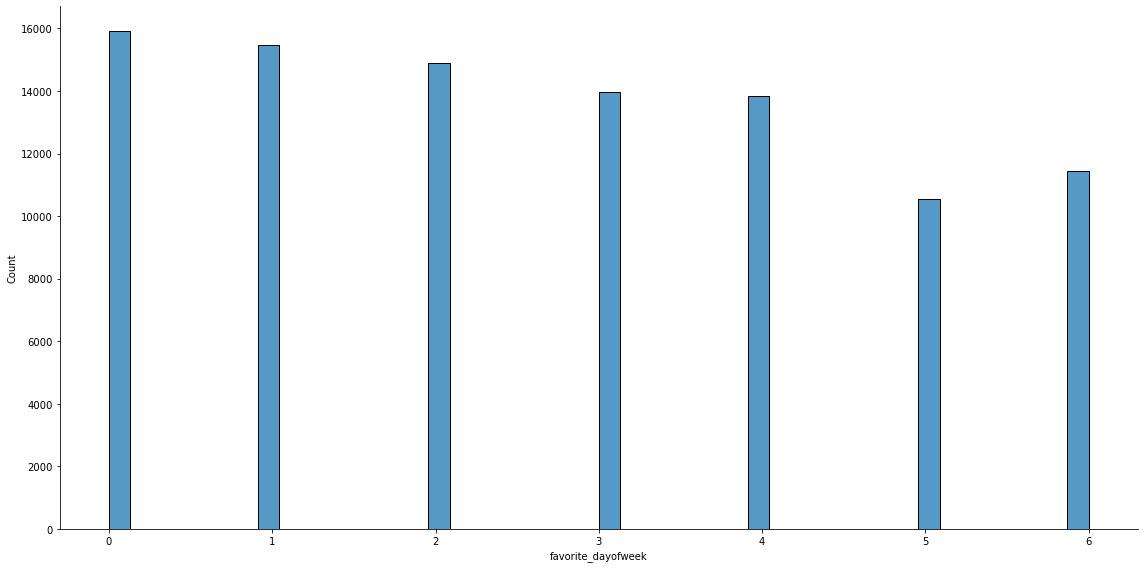

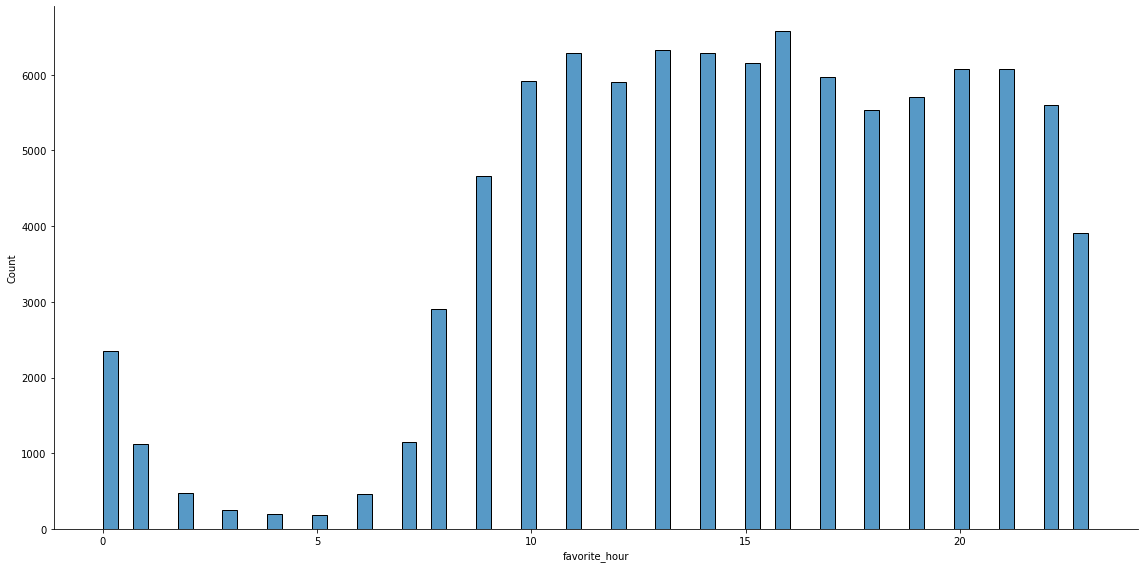

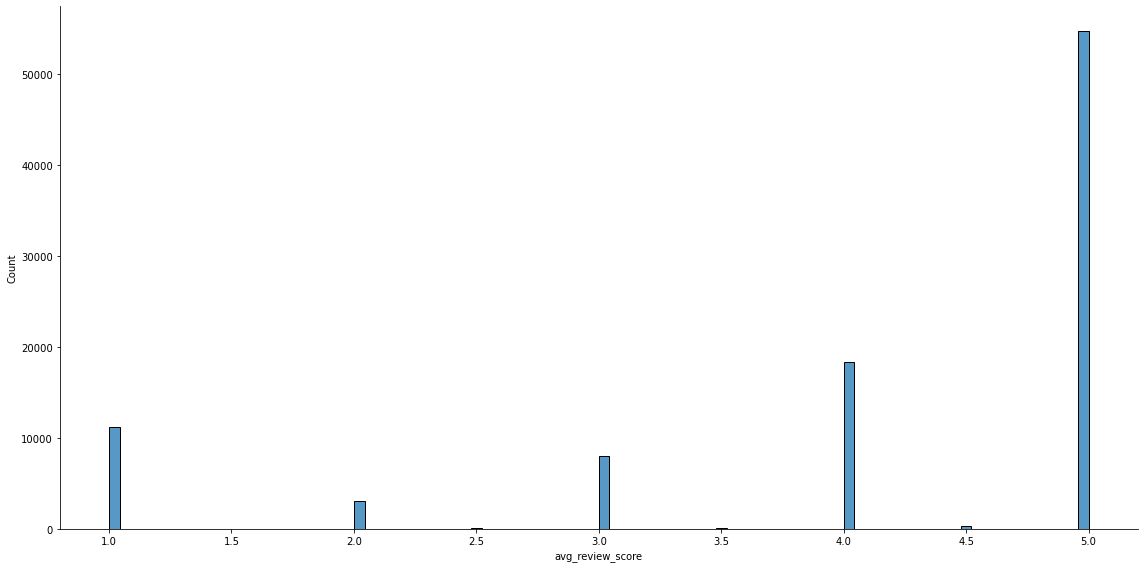

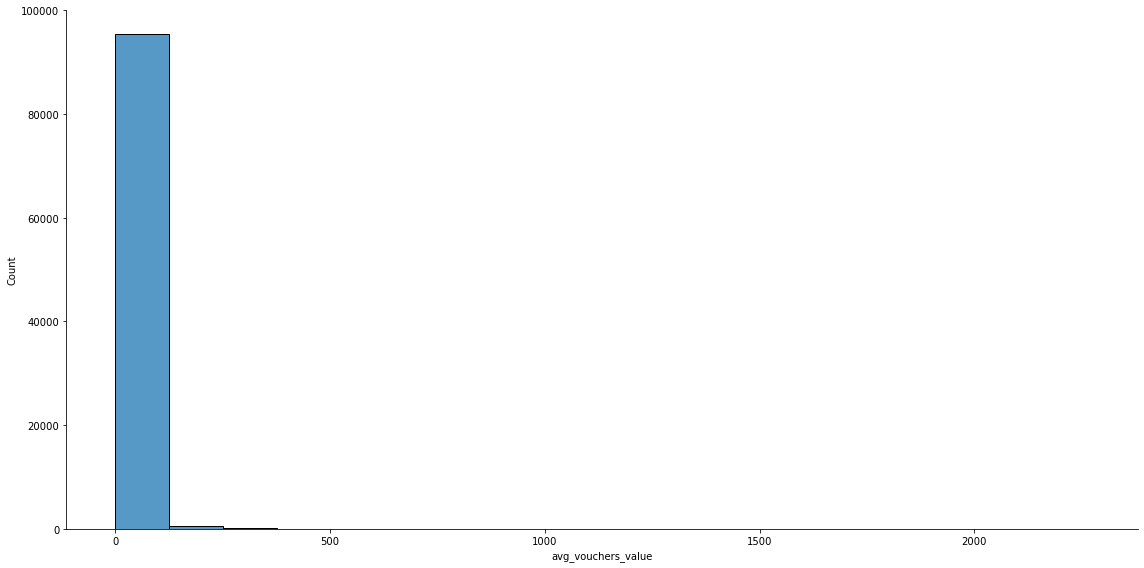

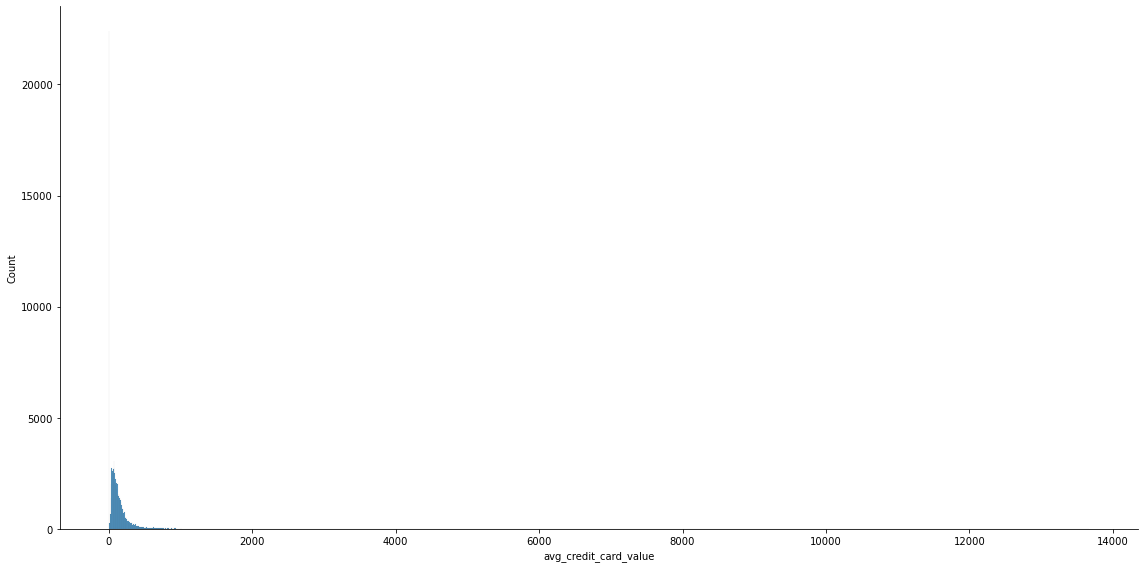

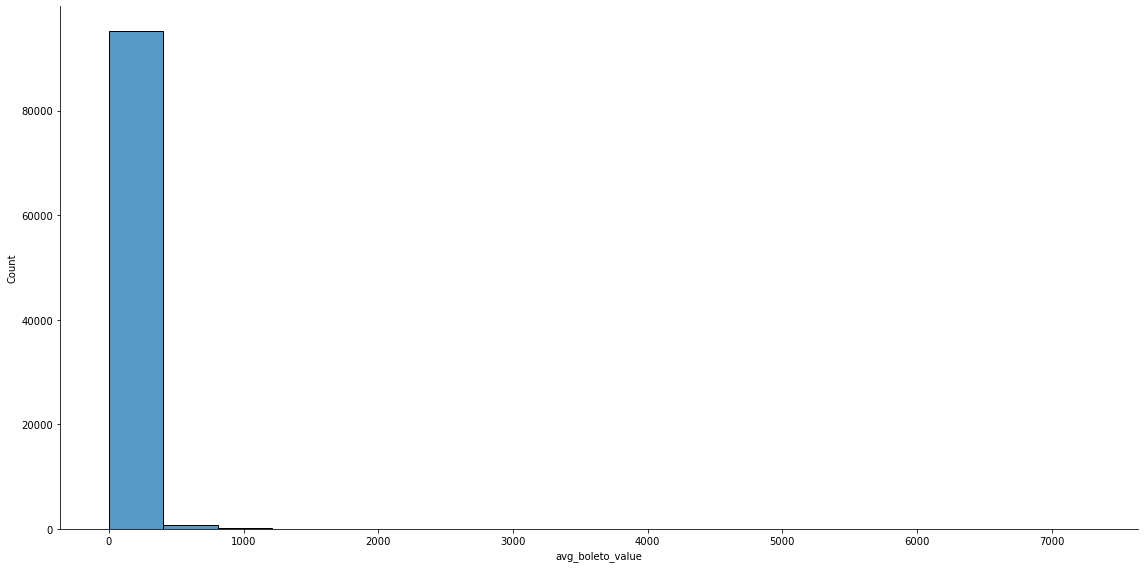

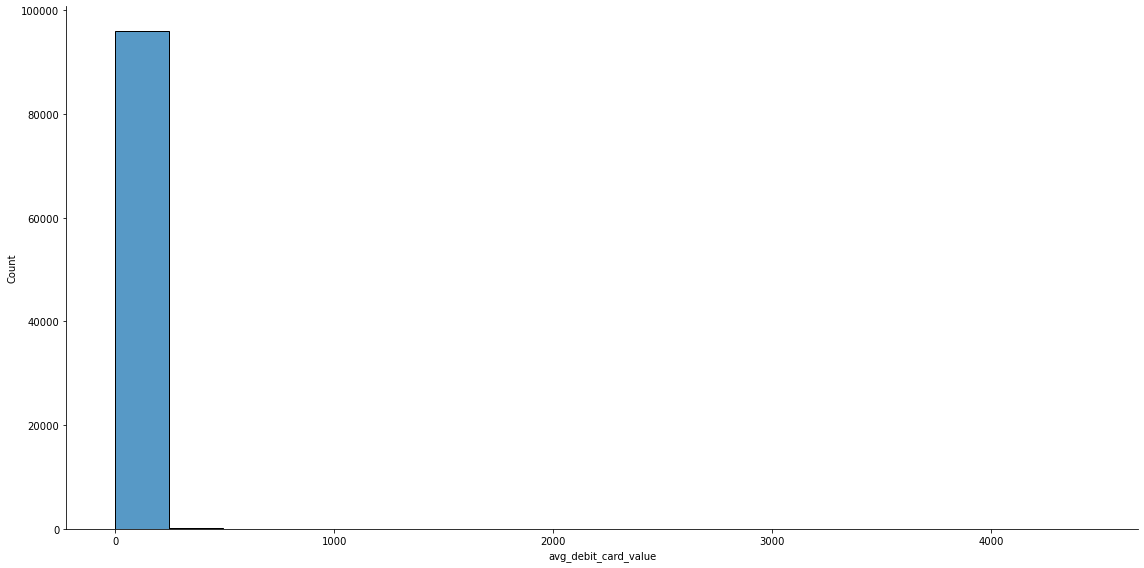

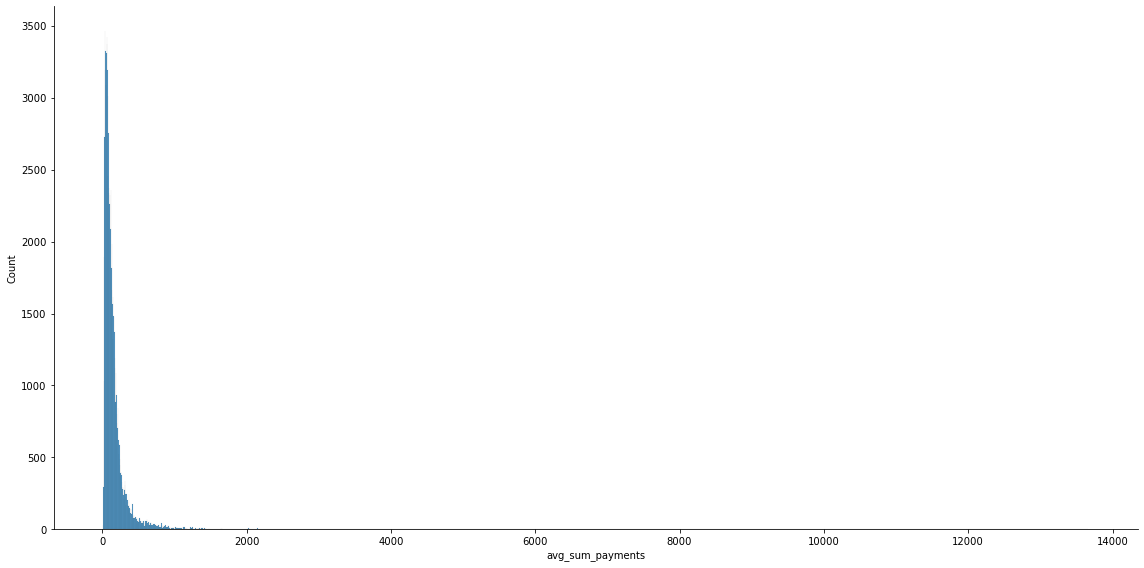

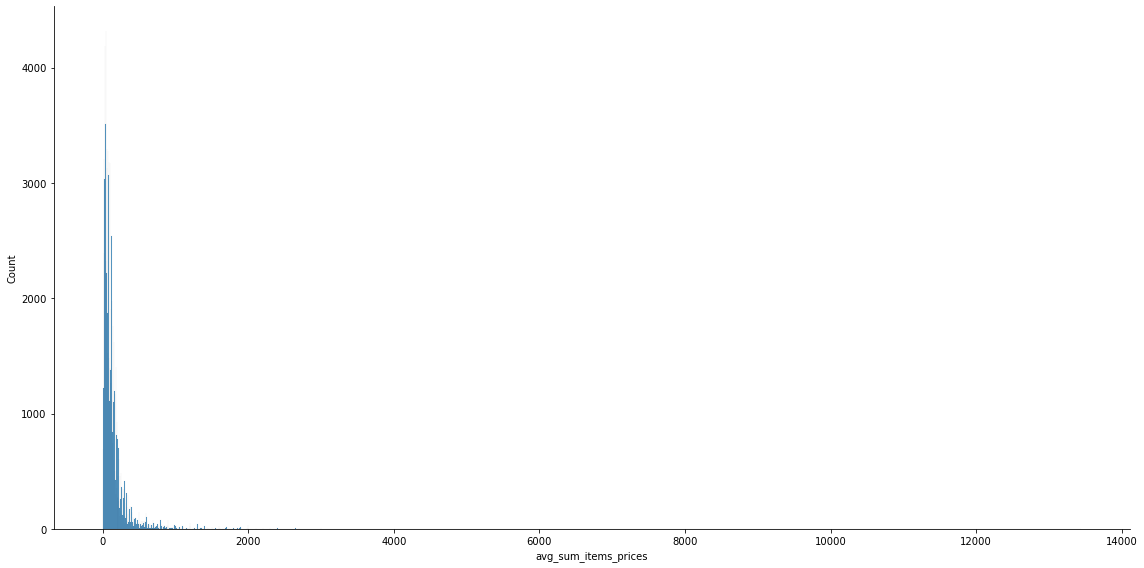

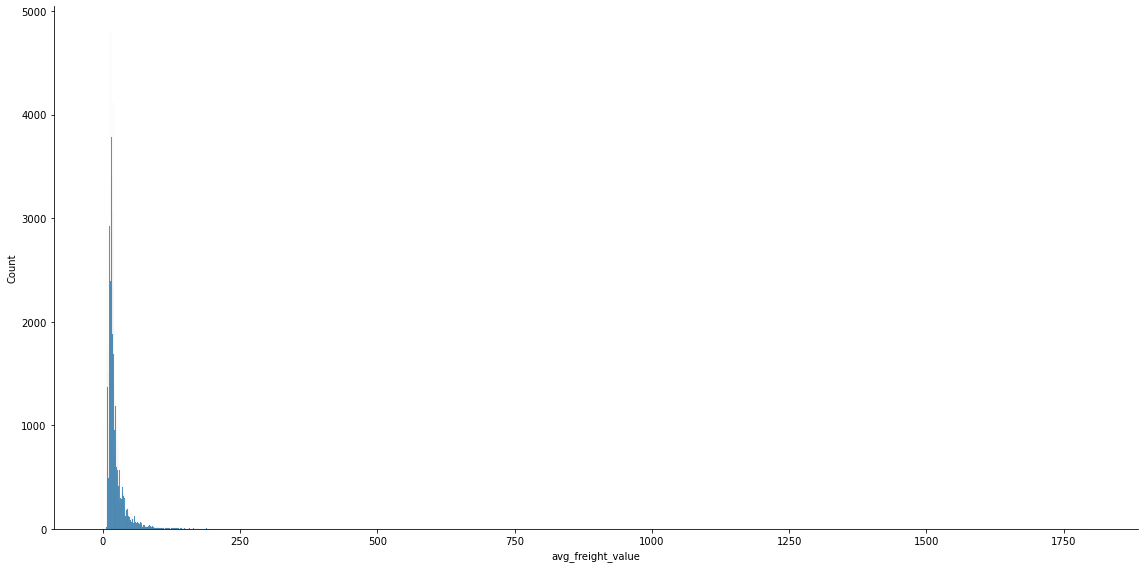

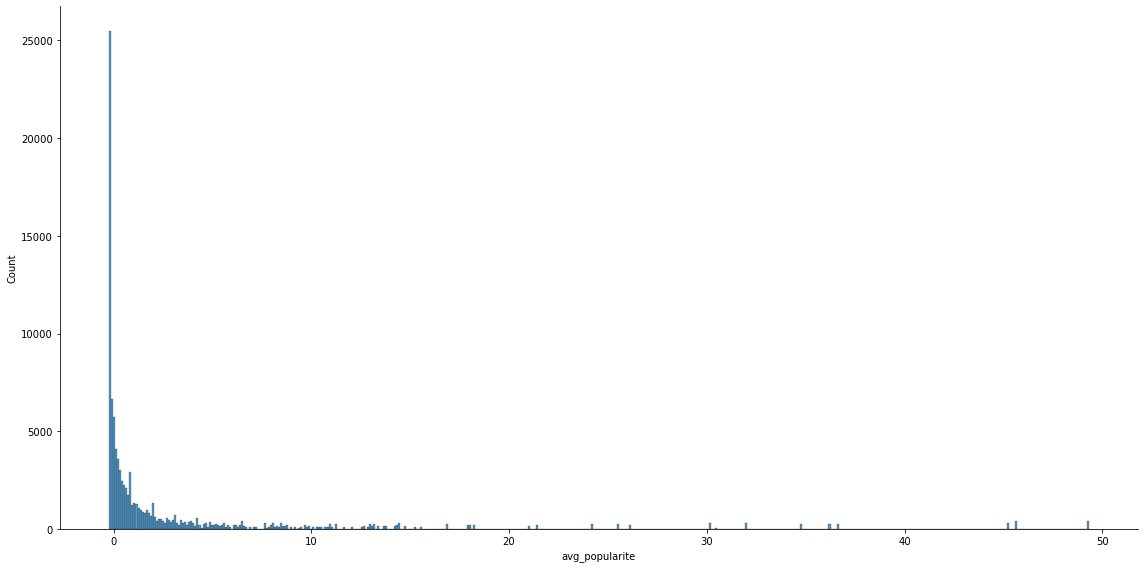

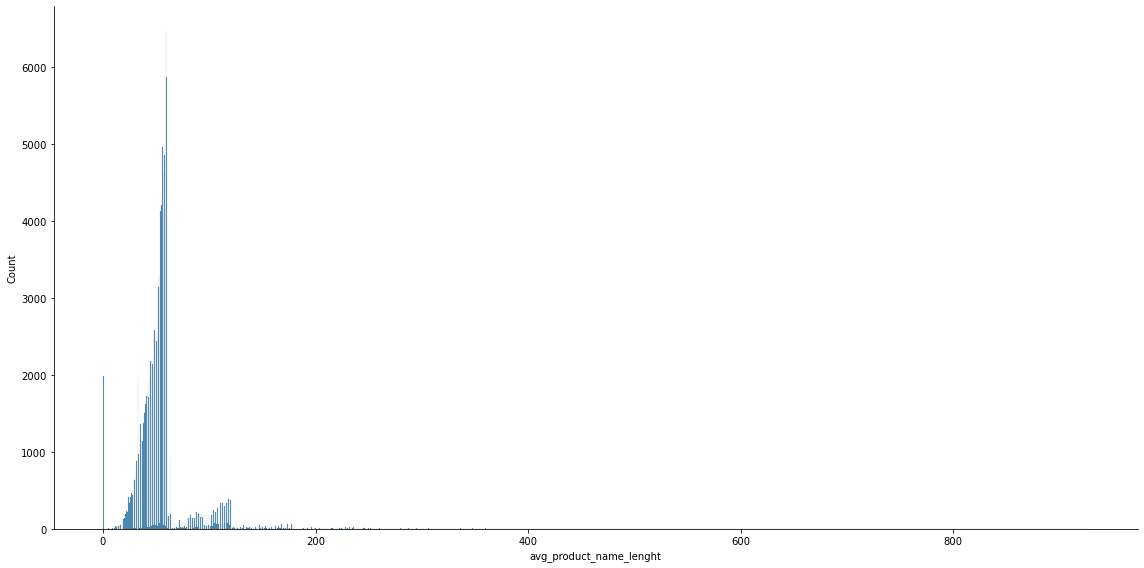

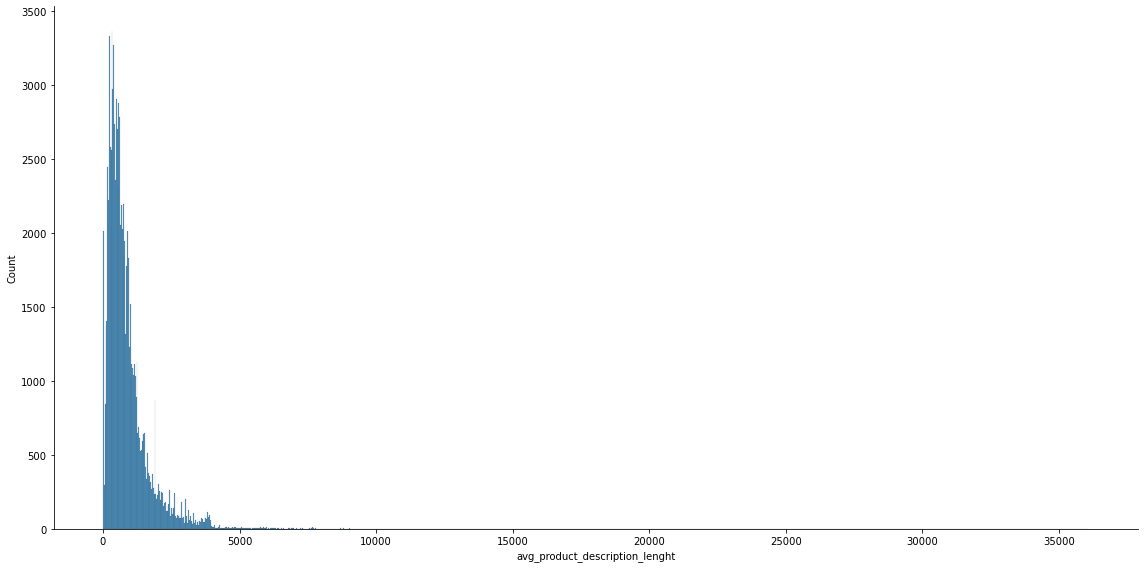

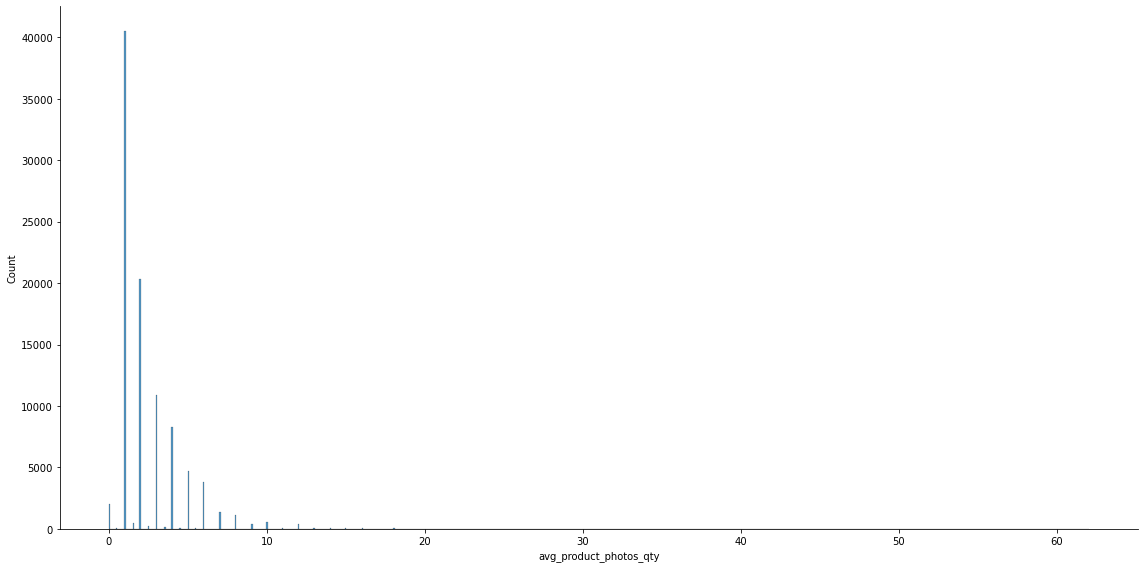

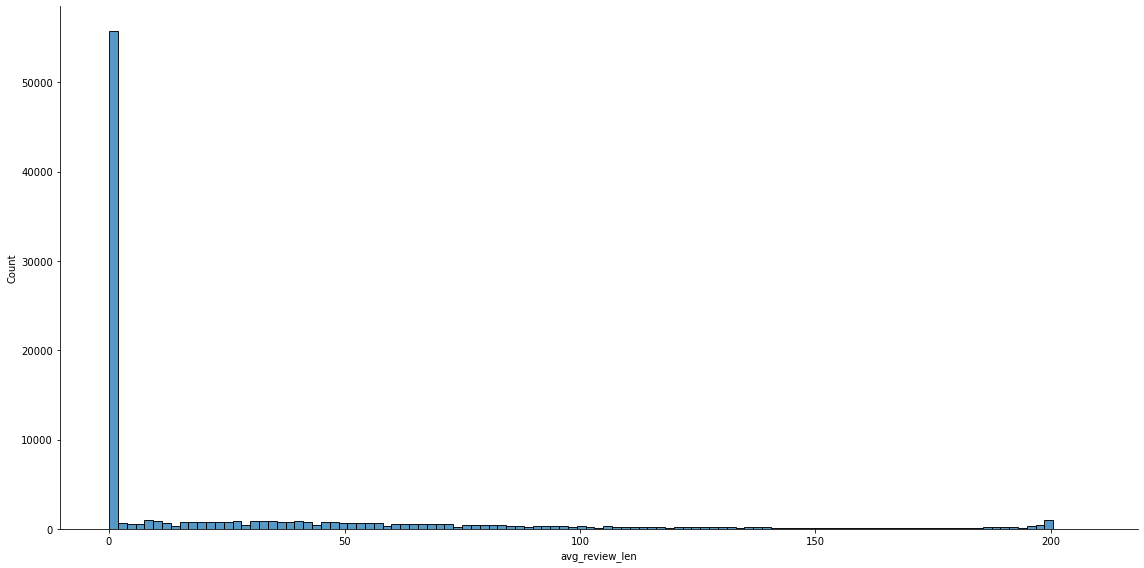

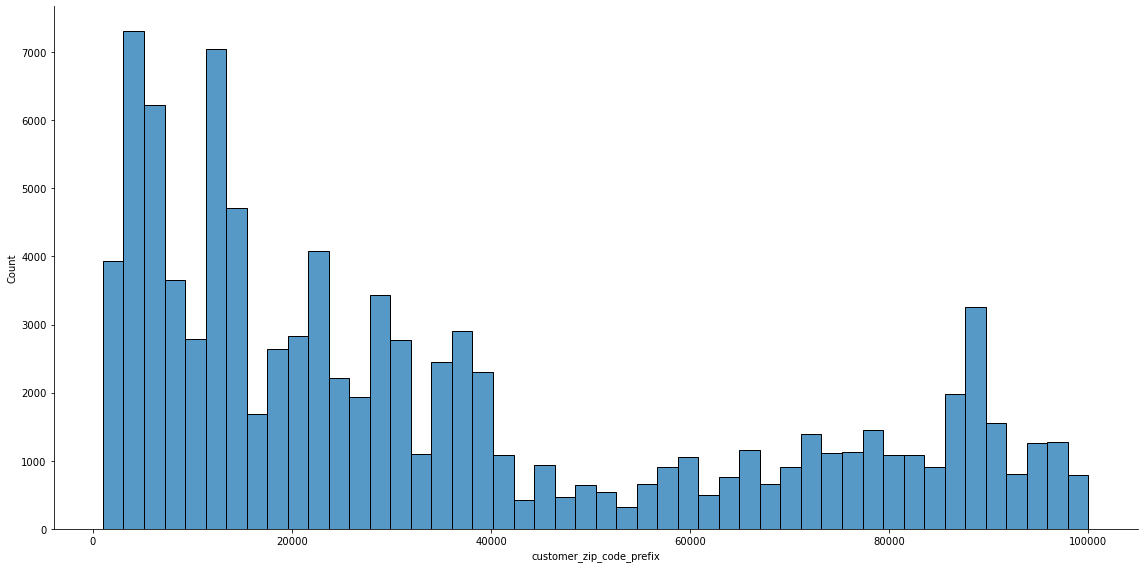

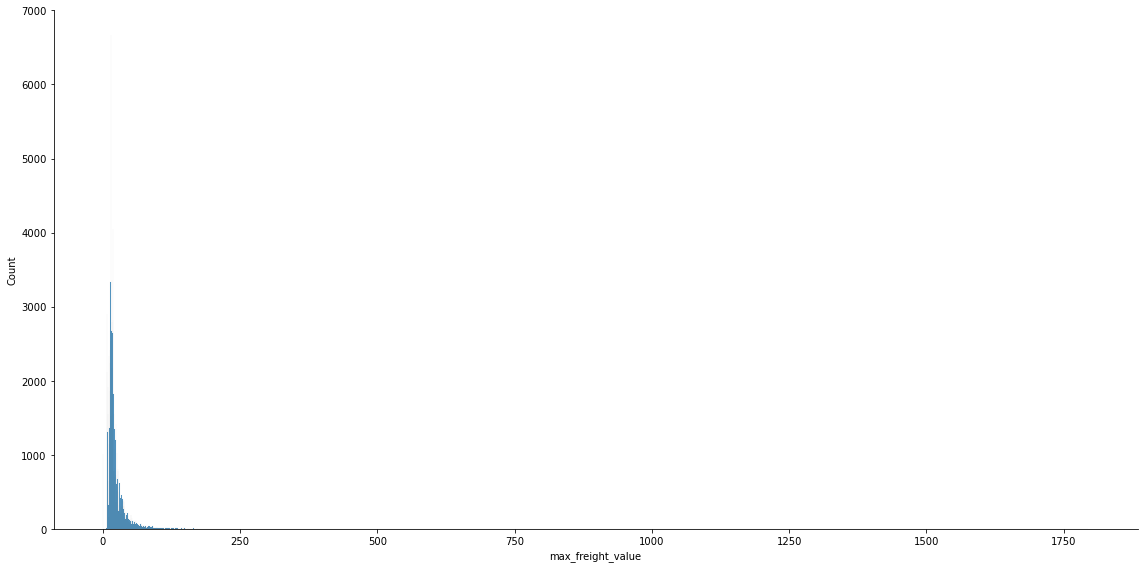

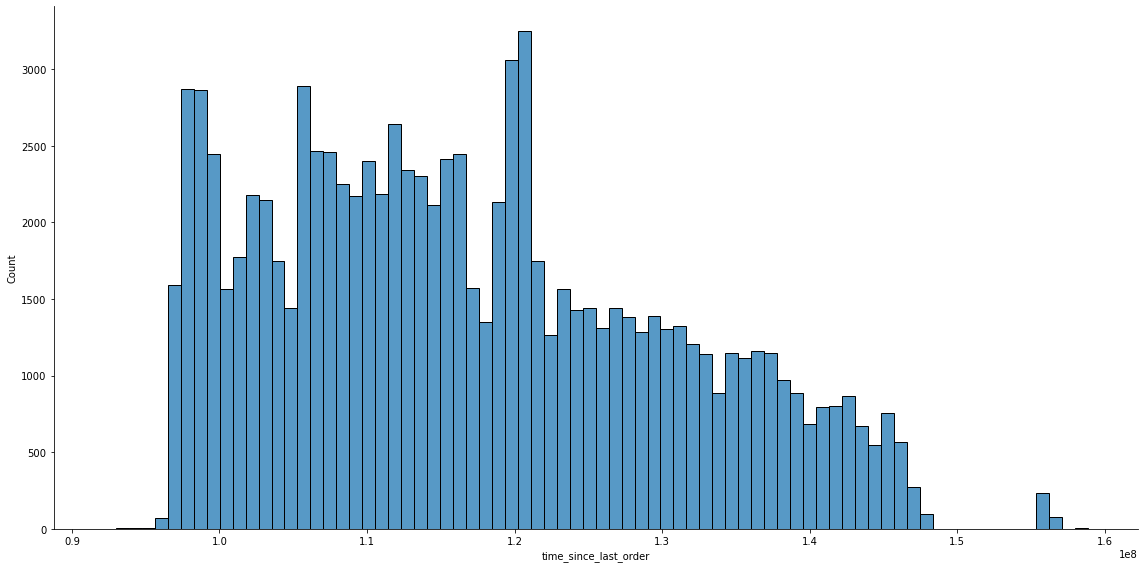

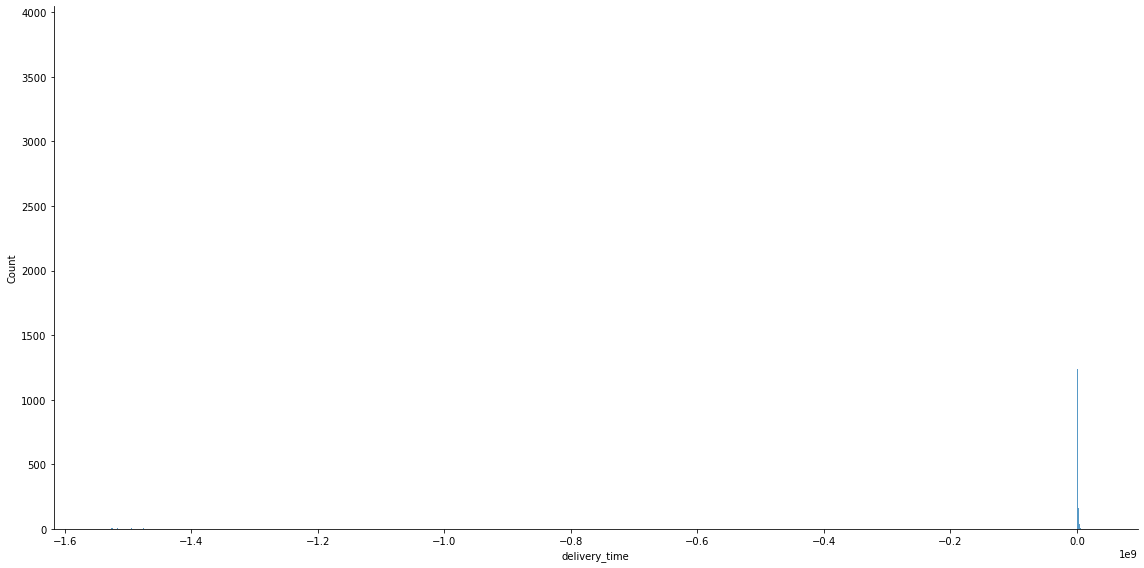

In [38]:
for col in clients.columns:
    sns.displot(clients, x=col, height=8, aspect=2)

Standardisation des données clients :

In [26]:
scaler = StandardScaler()
clients_std = scaler.fit_transform(clients)

In [21]:
# Cercle des corrélations
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(12,12))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)


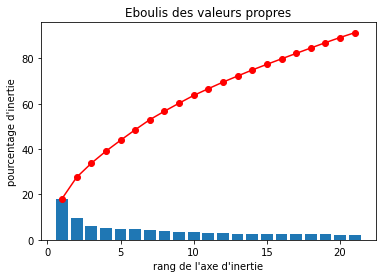

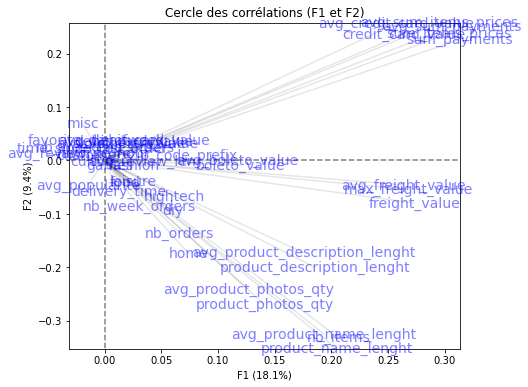

In [39]:
#pca = PCA(n_components=2)
# Ici on ne connait pas le nombre de composantes à calculer, on demande à scikit-learn de conserver 90% de la variance. 
pca = PCA(0.9)
pca.fit(clients_std)

# Eboulis des valeurs propres
from functions import *
display_scree_plot(pca)

pcs = pca.components_
display_circles(pcs, 2, pca, [(0,1)], labels = np.array(clients.columns))

In [15]:
clients_cluster = cluster.KMeans(n_clusters=10)
clients_cluster.fit(clients)

KMeans(n_clusters=10)